# Forecasting Dish Subscribers Using Gated Recurrent Units (GRUs) - Part 2

After developing our underlying approach in Part 1, we optimize our parameters using the tests below before generating our final predictions.

## Setup

First, we import the packages we need and define our file paths.

In [1]:
# Import packages
import numpy as np
import pandas as pd
from sklearn import preprocessing
from keras.layers import Input, GRU, Dense, concatenate, Activation
from keras.models import Model
import datetime
import sys
import random
import matplotlib as mpl
import matplotlib.pyplot as plt

# Set paths
path = "C:\\Users\\nthor\\Desktop\\Kaggle\\Python\\"
file = "Dish Datav2.xlsx" # Name of .xlsx file
sheet = "Data"

Using TensorFlow backend.


## Define Function

Next, we define the function we created in Part 1.

In [6]:
def run_GRU(trainingsize = 80,
             validation_size = 0,
             shuffle = False,
             GRUnodes = 64, 
             span = 10, 
             horiz = 8, 
             yweight = .3,
             n_epoch = 5000,
             verbose = False,
             save_figure = False): # Name of .xlsx sheetp
    
    # Set random seed
    seed = 2017
    np.random.seed(seed)
    
    ### Data Intake
    
    # Load data
    loc = path + file

    # Open spreadsheet
    Excel = pd.ExcelFile(loc)
    raw = Excel.parse(sheet)
    
   # Load variables (convert to float64 to pre-empt modeling issues)
    lastrow = len(raw) # Find the last row (valid + forecast)

    t = raw.iloc[0:lastrow, 0].astype('float64') # Time-steps (1,2, etc.)
    dates = raw.iloc[0:lastrow, 1] # Quarter dates (e.g., 1996Q1)
    newcust = raw.iloc[0:lastrow, 2].astype('float64') # Number of new Pay-TV customers
    cumcust = raw.iloc[0:lastrow, 3].astype('float64') # Cumulative number of Pay-TV customers
    q1 = raw.iloc[0:lastrow, 4].astype('float64') # Indicator for Q1 (created to capture seasonality effects)
    q2 = raw.iloc[0:lastrow, 5].astype('float64') # Indicator for Q1 (created to capture seasonality effects)
    q3 = raw.iloc[0:lastrow, 6].astype('float64') # Indicator for Q1 (created to capture seasonality effects)
    recession = raw.iloc[0:lastrow, 7].astype('float64') # Indicator for the 2008 recession
    subsidies = raw.iloc[0:lastrow, 8].astype('float64') # Dish promotional subsidies ($)
    rec_spend = raw.iloc[0:lastrow, 9].astype('float64') # US Census avg. recreational spend by household
    GDP = raw.iloc[0:lastrow, 10].astype('float64') # US GDP (%)
    newprod = raw.iloc[0:lastrow, 11].astype('float64') # Indicator for introduction of SlingTV (low cost "cut the cord" option that likely led to a spike in subscribers)

    ### Data Transformation & Model Preparation
    
    # Log-transform large variables to minimize outlier effects
    ln_rec_spend = np.log(rec_spend)
    ln_subsidies = np.log(subsidies)
    
    # Define x and y variables (named as '_1' to denote pre-normalized values)
    x_1 = pd.concat([q1, q2, q3, recession, ln_rec_spend, ln_subsidies, newprod], axis = 1)
    y_1 = newcust
    y_cum = cumcust 

    # Normalize metrics
    scaler_x = preprocessing.MinMaxScaler(feature_range = (0,1)) # Create scaler
    scaler_y = preprocessing.MinMaxScaler(feature_range = (0,1))

    x = np.array(x_1).reshape((len(x_1), len(x_1.columns))) # Reshape to avoid deprecation warning
    x = scaler_x.fit_transform(x) # Transform x elements

    y = np.array(y_1).reshape((len(y_1), 1))
    y = scaler_y.fit_transform(y)

    # Assemble matrices containing samples of x-spans, y-spans, and y-horizons across the available timeline
    nsample = lastrow - horiz - span # The number of samples equals the number of observations minus our number of time lag and prediction observations
    x_list = [np.expand_dims(np.atleast_2d(x[i:span + i,:]), axis = 0) for i in range(nsample)] # Group observations by our span parameter (2 by default)
    x_mat = np.concatenate(x_list, axis = 0) # Concatenate these lists into a single numpy array

    # Define y lag period
    ylag_list = [np.expand_dims(np.atleast_2d(y[i:span + i, :]), axis = 0) for i in range(nsample)]
    ylag_mat = np.concatenate(ylag_list, axis = 0) # Essentially are adding another list level: row to span period (2 by default)

    # Define target horizon
    y_list = [np.atleast_2d(y[i + span:span + i + horiz, 0]) for i in range(nsample)] # Groups the elements in y by our horizon parameter (i.e., groups 4 together into one list entry)
    y_mat = np.concatenate(y_list, axis = 0) # Concatenate all list entries

    # Define which observations (default of two span periods)
    ilast = nsample # We will later reset nsample to zero, so need to define a new variable
    xlast_list = [np.expand_dims(np.atleast_2d(x[ilast : ilast + span,:]), axis = 0)]
    xlast_mat = np.concatenate(xlast_list, axis = 0)

    # Define inputs to create forecasts
    ylastlag_list = [np.expand_dims(np.atleast_2d(y[ilast : ilast + span, :]), axis = 0)]
    ylastlag_mat = np.concatenate(ylastlag_list, axis = 0)

    ### Modeling
    
    # Define training sets
    end = y_mat.shape[0]
    learning_end = ((end) * trainingsize)//100 # Marks end of training set

    x_mat_train = x_mat[0:learning_end,] # Define x-variables in training set
    y_mat_train = y_mat[0:learning_end,] # Define y-variable in training set
    ylag_mat_train = ylag_mat[0:learning_end,] # Define lagging y-variables in training set

    # Define test sets
    x_mat_test = x_mat[learning_end + 1:lastrow,] # Define x-variables in test set
    y_mat_test = y_mat[learning_end + 1:lastrow,] # Contains 15-time spans, with each t+1 from the preceeding span equaling t in the proceeding span 
    ylag_mat_test = ylag_mat[learning_end + 1:lastrow,]
    
   # Create baseline ("main") GRU network
    main_in = Input(shape = (ylag_mat_train.shape[1], 1), dtype = 'float32', name = 'main_in') # Initialize input layer and define data shape
    main_gru = GRU(return_sequences = False, activation = 'tanh', units = GRUnodes, recurrent_activation = 'hard_sigmoid')(main_in) # Creates GRU with pre-defined number of nodes using tanh activation function
    main_out = Dense(horiz, activation = 'linear', name = 'main_out')(main_gru) # Implements the operation without any activation being applied (i.e., linear)

    # Create separate GRU network for both exogenous and endogenous metrics
    exo_in = Input(shape = (x_mat_train.shape[1], x_mat_train.shape[2]), dtype = 'float32', name = 'exo_in') # Shapes the input using the number of rows (2) and columns (7) in the array
    exo_gru = GRU(return_sequences = False, activation = 'tanh', units = GRUnodes, recurrent_activation = 'hard_sigmoid')(exo_in)
    exo_out = Dense(horiz, activation = 'linear', name = 'exo_out')(exo_gru)

    # Merge the two GRU layers
    merged_layers = concatenate([main_gru, exo_gru])

    # Create a dense layer for all merged data elements
    combo_out = Dense(horiz, activation = 'sigmoid', name = 'combo_out')(merged_layers)

    # Define final model input / output flows; compile parameters
    xyweight = 1 - yweight

    # Define final model input / output flows; compile parameters
    model = Model(inputs = [main_in, exo_in], outputs = [main_out, combo_out]) # Creates two lists of entries: our baseline and our combo
    model.compile(optimizer = 'rmsprop', 
                  loss = 'mean_squared_error', # Uses MSE as error term (rather than MAPE or alternatives) 
                  loss_weights = [yweight, xyweight]) 

    # Train the final model
    model.fit({'main_in' : ylag_mat_train, 
               'exo_in' : x_mat_train}, 
              {'main_out' : y_mat_train, 
               'combo_out':y_mat_train},
              epochs = n_epoch,
              shuffle = shuffle,
              validation_split = validation_size,
              verbose = verbose)

    # Test the final model
    pred = model.predict({'main_in' : ylag_mat_test, 'exo_in' : x_mat_test})    
    
   # Forecast y for predictor span that corresponds to horizon for which y(obs) is not known
    fcst = model.predict({'main_in' : ylastlag_mat, 'exo_in':xlast_mat})
    
    # Rescale predicted and observed values
    # pred is a list of two lists: pred[0][:] = baseline, pred[1][:] = combo
    for i in range(0, len(y_mat_test)):
        if i == 0:
            pred_s = scaler_y.inverse_transform(np.array(pred[1][i]).reshape((len(pred[1][i]), 1)))
            y_s = scaler_y.inverse_transform(np.array(y_mat_test[i]).reshape((len(y_mat_test[i]), 1)))
            fcst_s = scaler_y.inverse_transform(np.array(fcst[1][i]).reshape((len(fcst[1][i]), 1)))
        else:
            pred_s = np.concatenate([pred_s, scaler_y.inverse_transform(np.array(pred[1][i]).reshape((len(pred[1][i]), 1)))], axis = 1)
            y_s = np.concatenate([y_s, scaler_y.inverse_transform(np.array(y_mat_test[i]).reshape((len(y_mat_test[i]), 1)))], axis = 1)

    # Evaluate the model using three MAPE scores: overall loss, baseline loss, and combo loss
    MSE_train = model.evaluate({'main_in':ylag_mat_train, 'exo_in':x_mat_train},
                              {'main_out':y_mat_train, 'combo_out' : y_mat_train})

    MSE_test = model.evaluate({'main_in':ylag_mat_test, 'exo_in':x_mat_test},
                             {'main_out':y_mat_test, 'combo_out':y_mat_test})

    # Create finalized set of data
    Avg_OOS_Error_list = [] # initialize list to find minimum value
    # Select observed and predicted values
    for i in range(0, pred_s.shape[1] - 1): # for each time window (defined by 'span')
        nsample = i
        dat = dates[lastrow - horiz:lastrow]
        predictions = pred_s[0:horiz, nsample] # Select predictions
        observables = np.asarray(y_1[lastrow - horiz:lastrow]) # Select observed values
        diff = abs(observables - predictions) / observables * 100 # Perc. difference with respect to observed value
        diff_df = pd.DataFrame(data = diff, index = dat.index, columns = ['diff (%)'])
        Avg_OOS_Error = round(sum(diff_df.iloc[:, 0])/(horiz), 1) # find Avg. OOS MAPE
        Avg_OOS_Error_list.append(Avg_OOS_Error) # Store in list

    # Find sample with minimum MAPE
    min_MAPE = min(Avg_OOS_Error_list) # Find min
    i = [i for i, j in enumerate(Avg_OOS_Error_list) if j == min_MAPE] # Set sample to that min
    nsample = int(i[0])

    # Pull error terms for the correct sample    
    predictions = pred_s[0:horiz, nsample] # Select predictions
    observables = np.asarray(y_1[lastrow - horiz:lastrow]) # Select observed values
    forecasts = fcst_s[0:horiz, 0] # Select forecast values
    diff = abs(observables - predictions) / observables * 100 # Perc. difference with respect to observed value
    dat = dates[lastrow - horiz:lastrow]

    # Fix x-axis for forecast periods
    fcst_dates = pd.Series(['2017Q1', '2017Q2', '2017Q3', '2017Q4', '2018Q1', '2018Q2', '2018Q3', '2018Q4'], index = [84, 85, 86, 87, 88, 89, 90, 91], name = "Year / Quarter")
    dat_concat = dat.append(fcst_dates)

    # Convert to df
    pred_df = pd.DataFrame(data = predictions, index = dat.index, columns = ['predictions'])
    obs_df = pd.DataFrame(data = observables, index = dat.index, columns = ['observations'])
    f_df = pd.DataFrame(data = forecasts, index = dat.index + horiz, columns = ['forecasts']) 
    diff_df = pd.DataFrame(data = diff, index = dat.index, columns = ['diff (%)'])

    # Capture error terms
    Avg_OOS_Error = round(sum(diff_df.iloc[:, 0])/(horiz), 1)

    # Report average OOS-sample error terms
    print ("Avg. Out-of-Sample Error: ", Avg_OOS_Error, "%") # Report lowest OOS MAPE

    # Concatenate dataframes into predictions vs. obsefvations
    output_df = pd.concat([dat_concat, pred_df, obs_df, diff_df,f_df], axis = 1)
    
    # Set output size
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 9
    fig_size[1] = 6
    plt.rcParams["figure.figsize"] = fig_size

    # Visualize outputs
    plt.clf()
    plt.plot(output_df['predictions'], color = 'blue', lw = 2, marker = 'o')
    plt.plot(output_df['observations'], color = 'black', lw = 2, marker = 's')
    plt.plot(output_df['forecasts'], color = 'aqua', lw = 2, marker = 'o')
    plt.xticks(output_df.index, output_df['Year / Quarter'], rotation = 'vertical')
    plt.xlabel('Year / Quarter')
    plt.ylabel('New Subscribers')
    plt.legend(loc = 'lower left')
    plt.show()
    
    # Save the output
    if save_figure == True:
        fig_dest = path + "Final_Output.png"
        plt.savefig(fig_dest)


## Optimize Parameters
First, let's quickly run our new function to ensure that it's working correctly.

13/13 [==============================] - 0sA: 0s
Avg. Out-of-Sample Error:  21.6 %


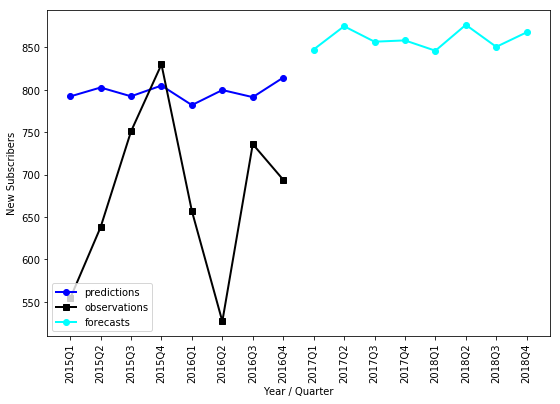

In [7]:
run_GRU(horiz = 8, n_epoch = 50, shuffle = False, span = 10)

### Span
Next, we will see what happens when we test different 'span' periods for our time-series model. Every time we increase our span by 1, we include an additional lag variable in our 'main' GRU. 

Span:  2
14/14 [==============================] - 0sA: 0s
Avg. Out-of-Sample Error:  11.9 %


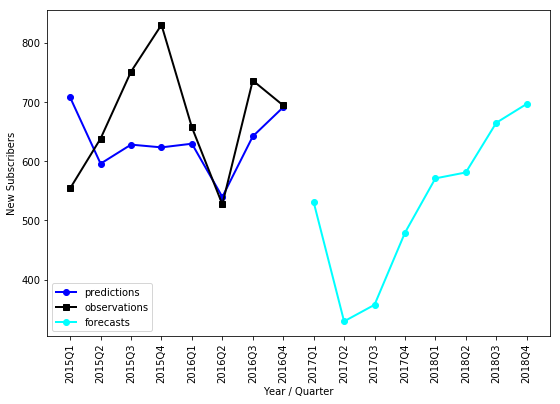

Span:  3
14/14 [==============================] - 0sA: 0s
Avg. Out-of-Sample Error:  17.3 %


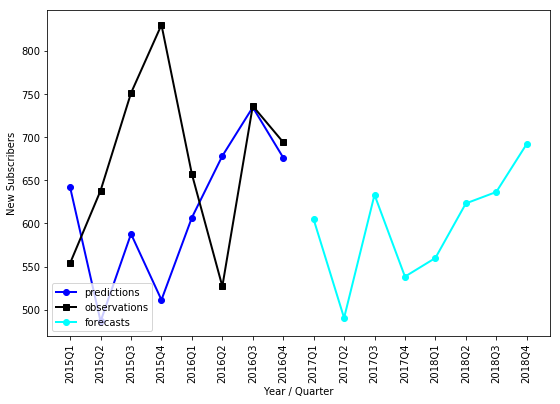

Span:  4
14/14 [==============================] - 0sA: 0s
Avg. Out-of-Sample Error:  12.4 %


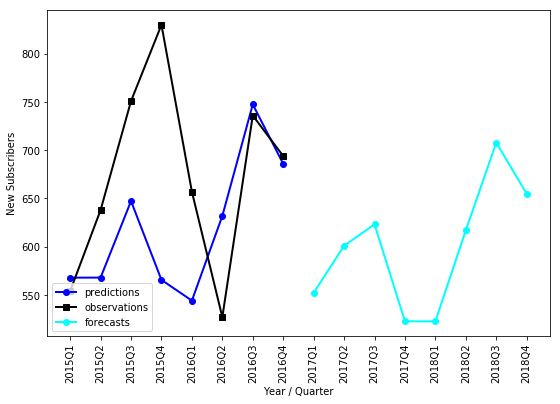

Span:  5
14/14 [==============================] - 0sA: 0s
Avg. Out-of-Sample Error:  16.6 %


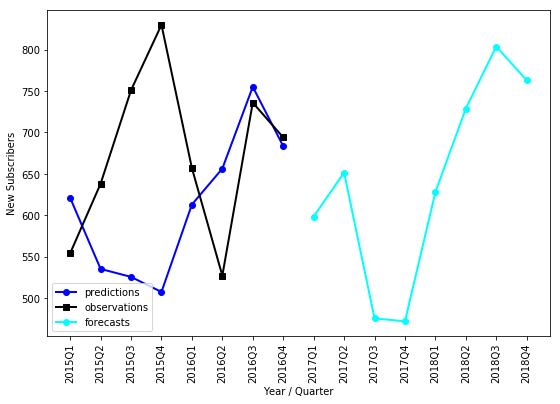

Span:  6
13/13 [==============================] - 0sA: 0s
Avg. Out-of-Sample Error:  13.1 %


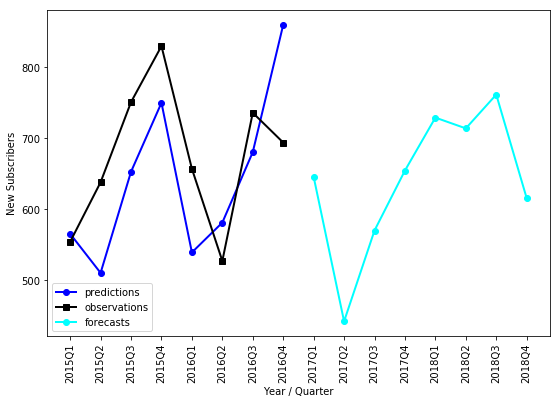

Span:  7
13/13 [==============================] - 0sA: 0s
Avg. Out-of-Sample Error:  10.3 %


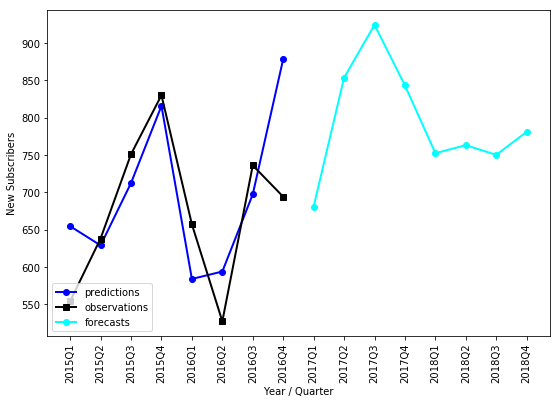

Span:  8
13/13 [==============================] - 0sA: 0s
Avg. Out-of-Sample Error:  17.7 %


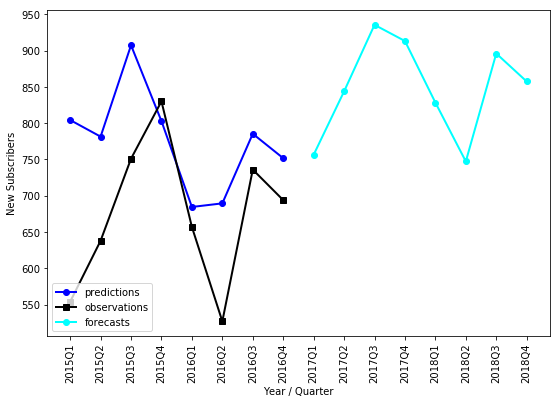

Span:  9
13/13 [==============================] - 0sA: 0s
Avg. Out-of-Sample Error:  16.8 %


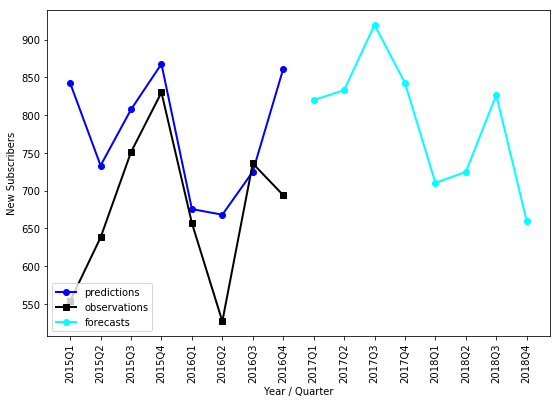

Span:  10
13/13 [==============================] - 0sA: 0s
Avg. Out-of-Sample Error:  11.7 %


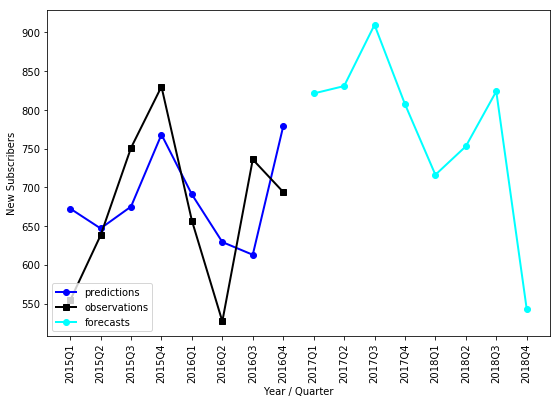

In [8]:
# Test different span periods
span_list = [2,3,4,5,6,7,8,9,10]

for i in span_list:
    print("Span: ", i)
    run_GRU(span = i, n_epoch = 5000)

As we increase our *span* periods, we notice that our forecasts more accurately capture seasonal fluctuations in new customers. Using 1.75 years worth of lag variables (span = 7) gives us an impressively low OOS absolute percent error.

### Ensemble Weights

To further improve our model, let's try adjusting our ensemble weights. The greater yweight is relative to xyweight, the more weight we put on our time-series GRU relative to our exogenous variable GRU.

Endogeneous GRU Weight:  0.1
13/13 [==============================] - 0sA: 0s
Avg. Out-of-Sample Error:  11.3 %


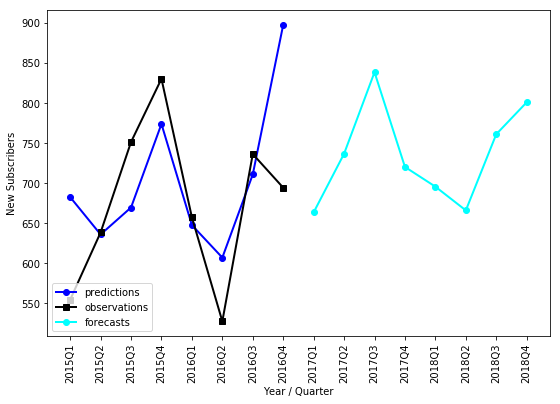

Endogeneous GRU Weight:  0.2
13/13 [==============================] - 0sA: 0s
Avg. Out-of-Sample Error:  10.3 %


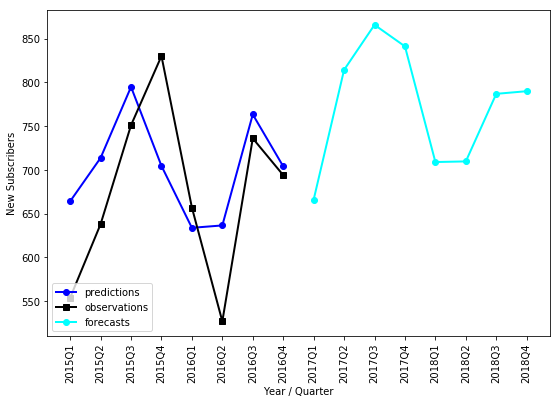

Endogeneous GRU Weight:  0.3
13/13 [==============================] - 0sA: 0s
Avg. Out-of-Sample Error:  12.5 %


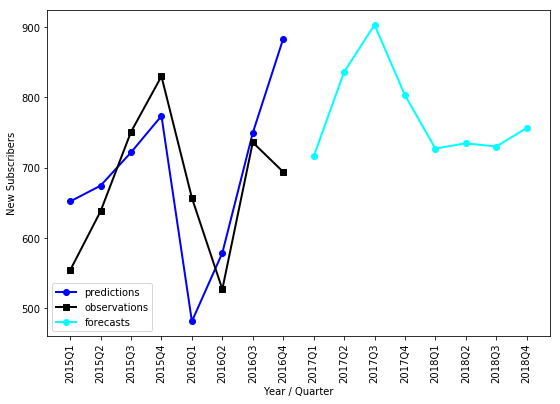

Endogeneous GRU Weight:  0.4
13/13 [==============================] - 0sA: 0s
Avg. Out-of-Sample Error:  10.9 %


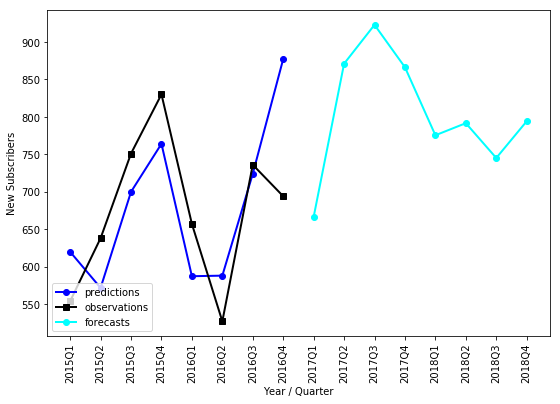

Endogeneous GRU Weight:  0.5
13/13 [==============================] - 0sA: 0s
Avg. Out-of-Sample Error:  10.3 %


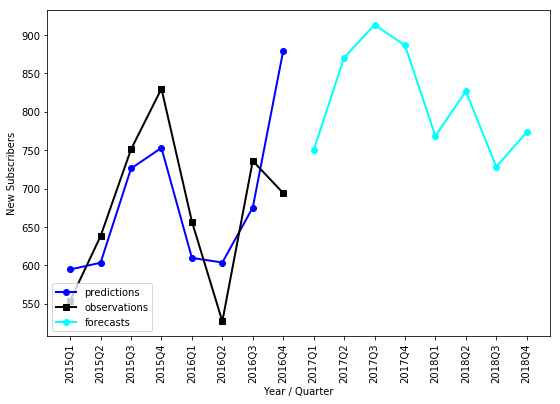

Endogeneous GRU Weight:  0.6
13/13 [==============================] - 0sA: 0s
Avg. Out-of-Sample Error:  11.0 %


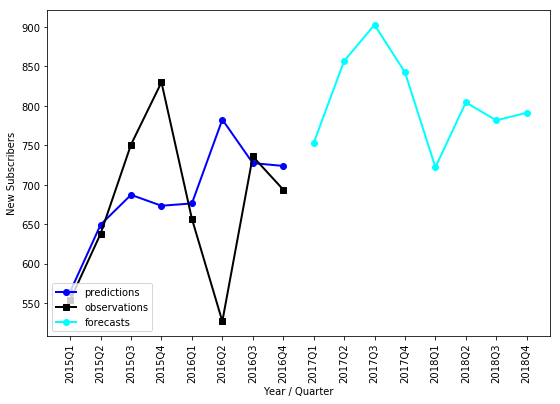

Endogeneous GRU Weight:  0.7
13/13 [==============================] - 0sA: 0s
Avg. Out-of-Sample Error:  14.9 %


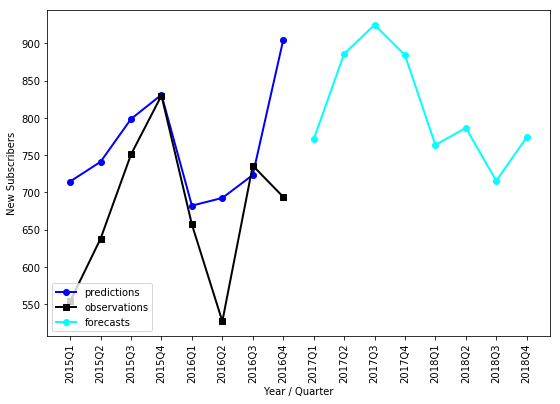

Endogeneous GRU Weight:  0.8
13/13 [==============================] - 0sA: 1s
Avg. Out-of-Sample Error:  13.3 %


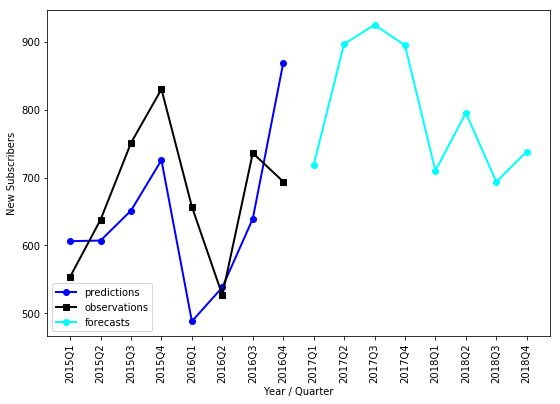

Endogeneous GRU Weight:  0.9
13/13 [==============================] - 0sA: 0s
Avg. Out-of-Sample Error:  11.4 %


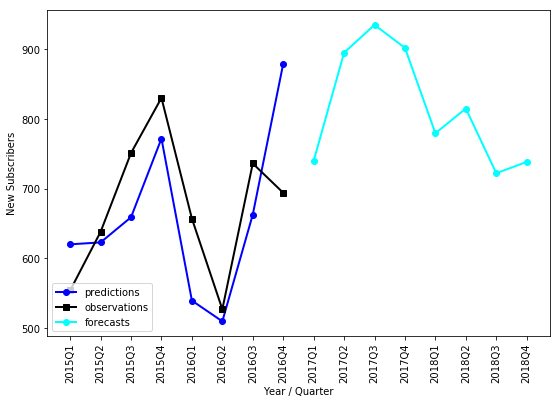

In [9]:
# Test different yweights periods
yweight_list = [.1, .2, .3, .4, .5, .6, .7, .8, .9]

for i in yweight_list:
    print ("Endogeneous GRU Weight: ", i)
    run_GRU(span = 7, yweight = i, n_epoch = 5000)

Adjusting the *yweight* parameter doesn't seem to make much of an impact on our OOS error term. To minimize our error term, we'll put 20% of the ensemble weight on our endogeneous variables and the rest on our exogenous variables.

### GRU Nodes
Finally, let's try adjusting the number of nodes in our GRU layers.

Number of GRU Nodes:  16
13/13 [==============================] - 0sA: 0s
Avg. Out-of-Sample Error:  9.2 %


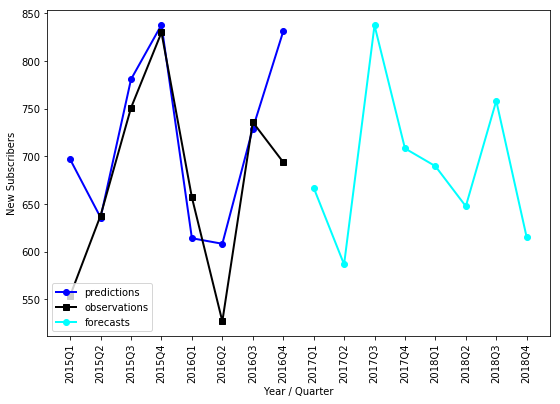

Number of GRU Nodes:  25
13/13 [==============================] - 0sA: 0s
Avg. Out-of-Sample Error:  11.2 %


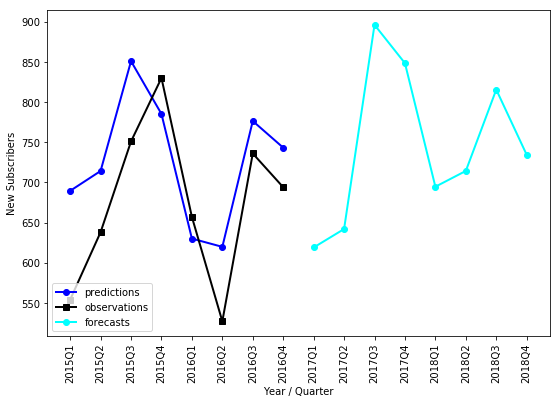

Number of GRU Nodes:  36
13/13 [==============================] - 0sA: 1s
Avg. Out-of-Sample Error:  10.2 %


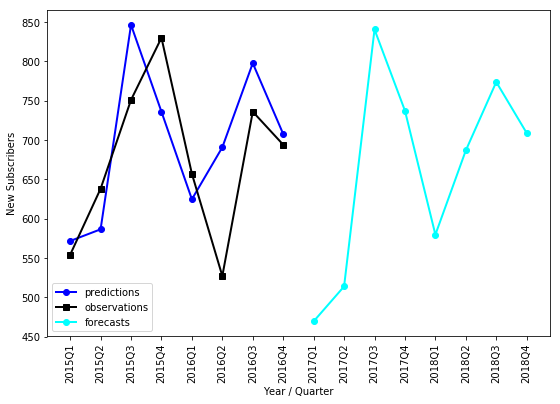

Number of GRU Nodes:  64
13/13 [==============================] - 0sA: 1s
Avg. Out-of-Sample Error:  10.9 %


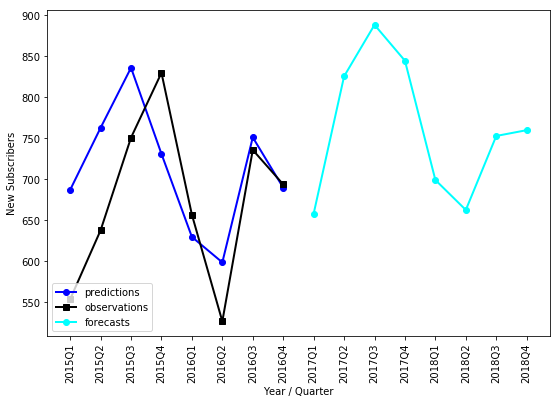

Number of GRU Nodes:  81
13/13 [==============================] - 0sA: 0s
Avg. Out-of-Sample Error:  11.5 %


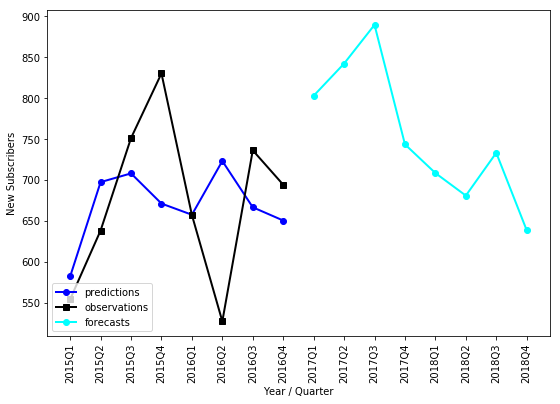

Number of GRU Nodes:  100
13/13 [==============================] - 0sA: 1s
Avg. Out-of-Sample Error:  11.1 %


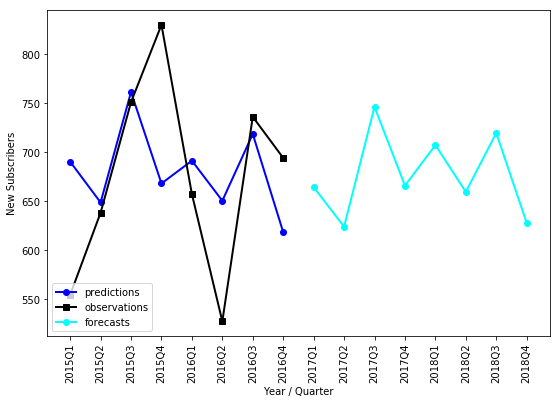

Number of GRU Nodes:  121
13/13 [==============================] - 0sA: 1s
Avg. Out-of-Sample Error:  13.0 %


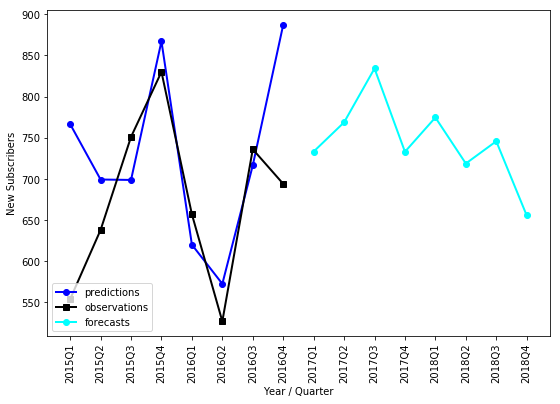

In [10]:
# Test different number of GRU nodes
GRUnodes_List = [16,25,36,64,81,100,121]

for i in GRUnodes_List:
    print ("Number of GRU Nodes: ", i)
    run_GRU(span = 7, yweight = .2, n_epoch = 5000, GRUnodes = i)

We notice that our model actually performs *worse* as we increase the number of nodes in our GRU, likely due to overfitting. Let's test a smaller sample to find the optimum number of nodes.

Number of GRU Nodes:  4
13/13 [==============================] - 0sA: 1s
Avg. Out-of-Sample Error:  10.6 %


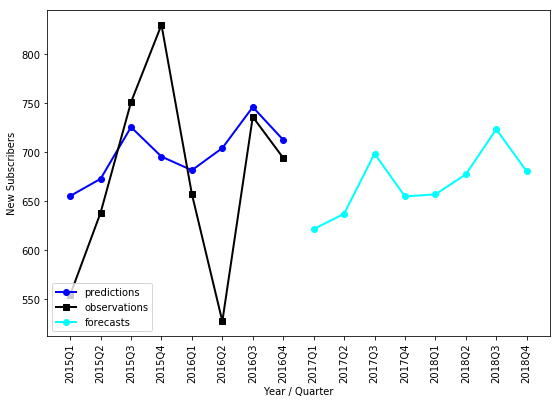

Number of GRU Nodes:  6
13/13 [==============================] - 0sA: 1s
Avg. Out-of-Sample Error:  12.9 %


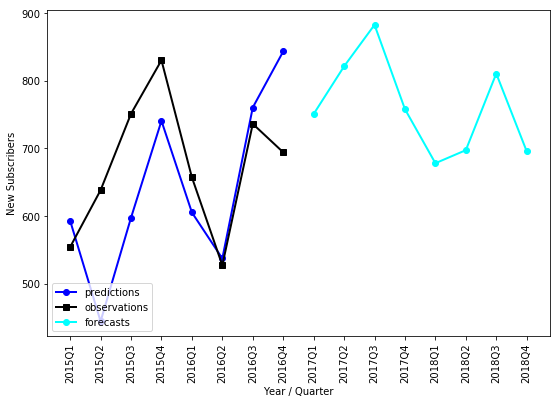

Number of GRU Nodes:  8
13/13 [==============================] - 0sA: 1s
Avg. Out-of-Sample Error:  9.3 %


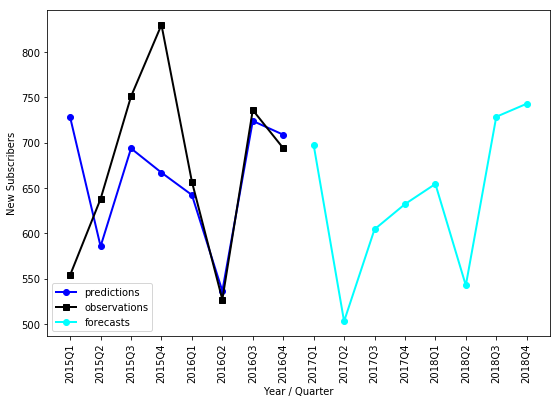

Number of GRU Nodes:  10
13/13 [==============================] - 0sA: 1s
Avg. Out-of-Sample Error:  11.3 %


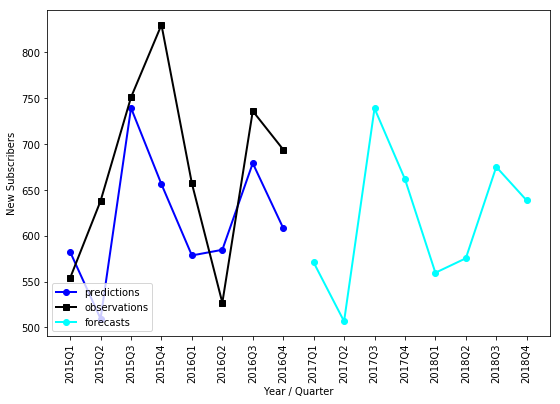

Number of GRU Nodes:  12
13/13 [==============================] - 0sA: 1s
Avg. Out-of-Sample Error:  8.3 %


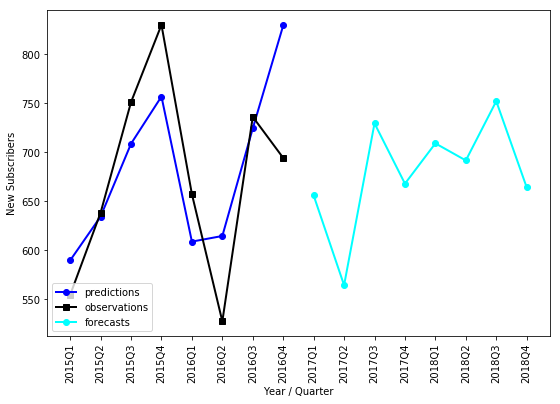

Number of GRU Nodes:  14
13/13 [==============================] - 0sA: 1s
Avg. Out-of-Sample Error:  10.2 %


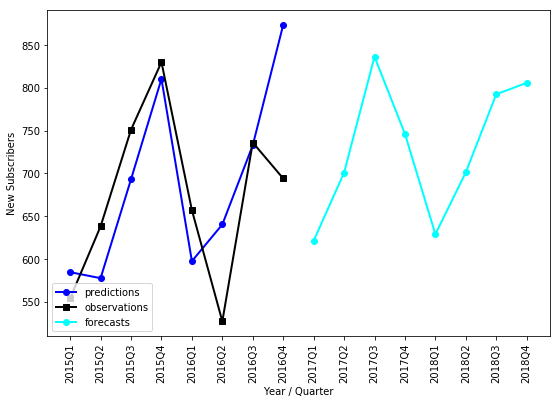

Number of GRU Nodes:  16
13/13 [==============================] - 0sA: 1s
Avg. Out-of-Sample Error:  8.8 %


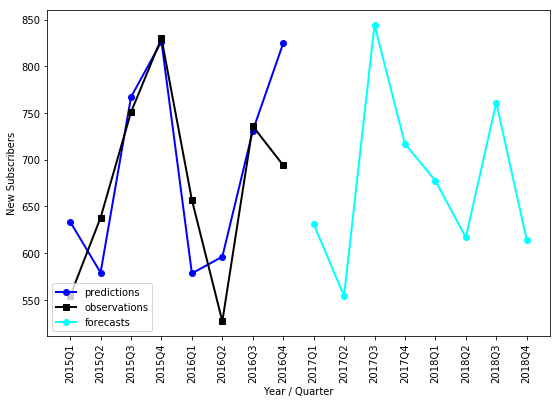

Number of GRU Nodes:  18
13/13 [==============================] - 0sA: 1s
Avg. Out-of-Sample Error:  12.5 %


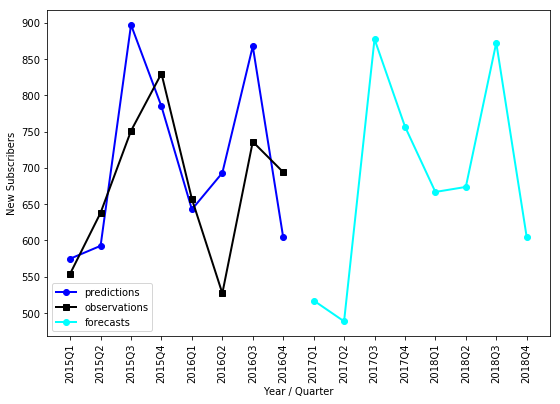

In [18]:
# Test smaller subset of GRU nodes
for i in range(4, 20, 2):
    print ("Number of GRU Nodes: ", i)
    run_GRU(span = 7, yweight = .2, n_epoch = 5000, GRUnodes = i)

We're starting to split hairs at this end of the scale, but it seems as though using 12 nodes in our GRU layer will minimize our error term. We begin to see a higher degree of overfitting as the number of GRU nodes increases.

## Final Model 
At long last, we're ready to build our final model and save our visualization.

13/13 [==============================] - 0sA: 2s
Avg. Out-of-Sample Error:  8.2 %


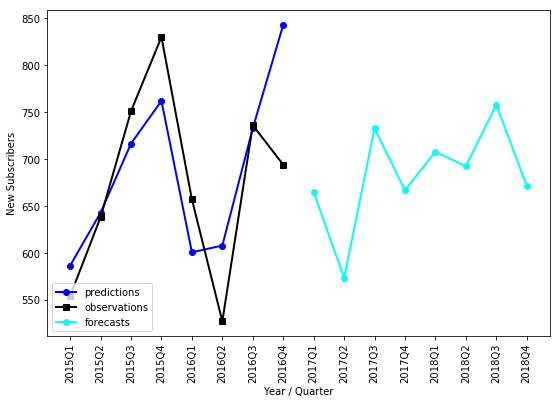

In [19]:
run_GRU(trainingsize = 80, span = 7, horiz = 8, yweight = .2, n_epoch = 5000, GRUnodes = 12, shuffle = False, save_figure = True)